# Part 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

np.random.seed(12345)  # For reproducibility
plt.style.use('seaborn-v0_8-darkgrid')

print("="*80)
print("HOMEWORK: PREDICTING FIRM EXPORT BEHAVIOR")
print("="*80)

# ============================================================================
# DATA GENERATION (DO NOT MODIFY)
# ============================================================================
print("\nGenerating synthetic firm data...")

n_firms = 2500

# Firm characteristics
firm_size = np.random.lognormal(4, 1.5, n_firms)  # Number of employees
productivity = np.random.lognormal(0, 0.8, n_firms)  # TFP measure
capital_intensity = np.random.lognormal(2, 1, n_firms)  # Capital per worker
firm_age = np.random.exponential(10, n_firms)  # Years since founding
rd_intensity = np.random.beta(2, 8, n_firms)  # R&D spending / revenue
skill_ratio = np.random.beta(3, 2, n_firms)  # Share of skilled workers
distance_to_port = np.random.exponential(50, n_firms)  # km
foreign_ownership = np.random.binomial(1, 0.15, n_firms)  # Binary
industry_concentration = np.random.beta(2, 5, n_firms)  # HHI measure
credit_rating = np.random.normal(3, 1, n_firms)  # 1-5 scale

# Generate export probability with complex non-linear relationships
export_logit = (
    0.3 * np.log(firm_size) +
    0.5 * productivity +
    -0.0005 * (firm_size - 100)**2 +  # Non-linear size effect
    0.15 * np.log(capital_intensity) +
    0.02 * firm_age +
    -0.0005 * firm_age**2 +  # Non-linear age effect
    2.0 * rd_intensity +
    1.5 * skill_ratio +
    -0.01 * distance_to_port +
    0.8 * foreign_ownership +
    -1.0 * industry_concentration +
    0.3 * credit_rating +
    0.4 * (productivity * skill_ratio) +  # Interaction effect
    -4.0  # Intercept
)

export_prob = 1 / (1 + np.exp(-export_logit))
exports = (export_prob > 0.5).astype(int)

# Add some random noise (10% label noise)
noise_idx = np.random.choice(n_firms, size=int(0.1 * n_firms), replace=False)
exports[noise_idx] = 1 - exports[noise_idx]

# Create DataFrame
firm_data = pd.DataFrame({
    'firm_size': firm_size,
    'productivity': productivity,
    'capital_intensity': capital_intensity,
    'firm_age': firm_age,
    'rd_intensity': rd_intensity,
    'skill_ratio': skill_ratio,
    'distance_to_port': distance_to_port,
    'foreign_ownership': foreign_ownership,
    'industry_concentration': industry_concentration,
    'credit_rating': credit_rating,
    'exports': exports
})

print("\nDataset created!")
print(f"Number of firms: {n_firms}")
print(f"Export rate: {exports.mean():.1%}")
print(f"\nFirst 5 rows:")
print(firm_data.head())
print(f"\nSummary statistics:")
print(firm_data.describe())

# Split into train/test (DO NOT MODIFY THIS SPLIT)
X = firm_data.drop('exports', axis=1)
y = firm_data['exports']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nTraining set: {len(X_train)} firms")
print(f"Test set: {len(X_test)} firms")

HOMEWORK: PREDICTING FIRM EXPORT BEHAVIOR

Generating synthetic firm data...

Dataset created!
Number of firms: 2500
Export rate: 20.5%

First 5 rows:
     firm_size  productivity  capital_intensity   firm_age  rd_intensity  \
0    40.162692      0.474420          10.484532  51.503025      0.214119   
1   111.990608      4.311103          17.523138  13.315504      0.298270   
2    25.049201      0.831859          12.327048  18.326290      0.304473   
3    23.722039      0.511259          43.033593   0.245316      0.124100   
4  1041.764156      0.460167           3.738639   0.563372      0.193848   

   skill_ratio  distance_to_port  foreign_ownership  industry_concentration  \
0     0.487321         53.703724                  0                0.098921   
1     0.599483          8.846959                  1                0.162346   
2     0.740494         68.085465                  0                0.393885   
3     0.588482         40.317104                  0                0.150759 

C:\Users\rka304\AppData\Local\Temp\ipykernel_203348\2468645874.py:54: RuntimeWarning: overflow encountered in exp
  export_prob = 1 / (1 + np.exp(-export_logit))


In [20]:
# ============================================================================
# QUESTION 1: EXPLORATORY DATA ANALYSIS (10 points)
# ============================================================================
print("\n" + "="*80)
print("QUESTION 1: EXPLORATORY DATA ANALYSIS (10 points)")
print("="*80)

"""
a) Create a correlation matrix heatmap of all features (3 points)
   - Include the export variable
   - Use a diverging colormap
   - Save as 'q1a_correlation.png'
"""
# YOUR CODE FOR (a):
# TODO: Create correlation heatmap
corr = firm_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Firm Features and Export Status')
plt.tight_layout()
plt.savefig('q1a_correlation.png')
plt.close()

"""
b) Create box plots comparing 3 key features between exporters and non-exporters (4 points)
   - Choose firm_size, productivity, and rd_intensity
   - Save as 'q1b_boxplots.png'
"""
# YOUR CODE FOR (b):
# TODO: Create box plots comparing exporters vs non-exporters
plt.figure(figsize=(15, 5))
features = ['firm_size', 'productivity', 'rd_intensity']
for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='exports', y=feature, data=firm_data)
    plt.title(f'Box Plot of {feature} by Export Status')
    plt.xlabel('Exports')
    plt.ylabel(feature)
plt.tight_layout()
plt.savefig('q1b_boxplots.png')
plt.close()


"""
c) Write a short interpretation (3 points):
   - Which features appear most correlated with exporting?
   - What patterns do you observe?

YOUR ANSWER FOR (c):
"""


QUESTION 1: EXPLORATORY DATA ANALYSIS (10 points)


'\nc) Write a short interpretation (3 points):\n   - Which features appear most correlated with exporting?\n   - What patterns do you observe?\n\nYOUR ANSWER FOR (c):\n'

In [21]:
# ============================================================================
# QUESTION 2: SINGLE DECISION TREE (15 points)
# ============================================================================
print("\n" + "="*80)
print("QUESTION 2: SINGLE DECISION TREE (15 points)")
print("="*80)

"""
a) Train a decision tree with max_depth=3 (3 points)
   - Use random_state=42
   - Report training and test accuracy
   
b) Visualize the tree structure (4 points)
   - Use plot_tree with filled=True
   - Save as 'q2b_tree_structure.png'
   
c) Train trees with max_depth = 1, 3, 5, 7, 10, 15, 20, None (5 points)
   - Plot training and test accuracy vs depth
   - Identify the optimal depth
   - Save plot as 'q2c_depth_comparison.png'
   
d) Interpretation (3 points):
   - What depth gives best test performance?
   - What happens with very deep trees?
   - Explain in terms of bias-variance tradeoff

"""

# YOUR CODE FOR (a):
# TODO: Train tree with max_depth=3
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)
y_train_pred = tree_clf.predict(X_train)
y_test_pred = tree_clf.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nDecision Tree (max_depth=3) Training Accuracy: {train_accuracy:.4f}")
print(f"Decision Tree (max_depth=3) Test Accuracy: {test_accuracy:.4f}")


# YOUR CODE FOR (b):
# TODO: Visualize tree structure

plt.figure(figsize=(20,10))
plot_tree(tree_clf, filled=True, feature_names=X_train.columns, class_names=['Non-Exporter', 'Exporter'])
plt.title("Decision Tree Structure (max_depth=3)")
plt.savefig('q2b_tree_structure.png')
plt.close()

# YOUR CODE FOR (c):
# TODO: Train trees with different depths and plot results
depths = [1, 3, 5, 7, 10, 15, 20, None]
train_accuracies = []
test_accuracies = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    train_accuracies.append(clf.score(X_train, y_train))
    test_accuracies.append(clf.score(X_test, y_test))
plt.figure(figsize=(10, 6))
plt.plot([str(d) for d in depths], train_accuracies, label='Training Accuracy', marker='o')
plt.plot([str(d) for d in depths], test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.legend()
plt.savefig('q2c_depth_comparison.png')
plt.close()

"""
YOUR ANSWER FOR (d):
"""


QUESTION 2: SINGLE DECISION TREE (15 points)

Decision Tree (max_depth=3) Training Accuracy: 0.7053
Decision Tree (max_depth=3) Test Accuracy: 0.6980


'\nYOUR ANSWER FOR (d):\n'

In [5]:
# ============================================================================
# QUESTION 3: RANDOM FOREST (20 points)
# ============================================================================
print("\n" + "="*80)
print("QUESTION 3: RANDOM FOREST (20 points)")
print("="*80)

"""
a) Train a Random Forest with default parameters (3 points)
   - n_estimators=500
   - Use oob_score=True
   - random_state=42
   - Report training, test, and OOB accuracy
   
b) Compare single tree vs Random Forest (4 points)
   - Use the best single tree from Q2
   - Create a bar plot comparing their test accuracies
   - Also compare precision, recall, and F1 score
   - Save as 'q3b_tree_vs_forest.png'
   
c) Study effect of number of trees (5 points)
   - Train forests with n_estimators = [10, 50, 100, 200, 500, 1000]
   - Plot OOB error vs number of trees
   - When does performance stabilize?
   - Save as 'q3c_num_trees.png'
   
d) Generate and analyze the confusion matrix (4 points)
   - Create confusion matrix for Random Forest on test set
   - Calculate: accuracy, precision, recall, F1
   - Which type of error is more common?
   - Save as 'q3d_confusion_matrix.png'
   
e) Interpretation (4 points):
   - Why does Random Forest outperform single tree?
   - What's the tradeoff between single tree and Random Forest?
   - How many trees would you recommend? Why?

YOUR ANSWER FOR (e):
[Write your interpretation here]

"""

# YOUR CODE FOR (a):
# TODO: Train Random Forest

rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)
rf.fit(X_train, y_train)
train_acc = rf.score(X_train, y_train)
test_acc = rf.score(X_test, y_test)
oob_acc = rf.oob_score_
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"OOB Accuracy: {oob_acc:.4f}")


# YOUR CODE FOR (b):
# TODO: Compare single tree vs RF
best_tree_depth = 5  # From Q2(c)
best_tree = DecisionTreeClassifier(max_depth=best_tree_depth, random_state=42)
best_tree.fit(X_train, y_train)
y_tree_pred = best_tree.predict(X_test)
tree_test_acc = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred, output_dict=True)
rf_report = classification_report(y_test, rf.predict(X_test), output_dict=True)
# Bar plot comparison
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
tree_metrics = [
    tree_test_acc,
    tree_report['1']['precision'],
    tree_report['1']['recall'],
    tree_report['1']['f1-score']
]
rf_metrics = [
    test_acc,
    rf_report['1']['precision'],
    rf_report['1']['recall'],
    rf_report['1']['f1-score']
]
x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, tree_metrics, width, label='Single Tree')
plt.bar(x + width/2, rf_metrics, width, label='Random Forest')
plt.ylabel('Scores')
plt.title('Single Decision Tree vs Random Forest Performance')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.savefig('q3b_tree_vs_forest.png')
plt.close() 

# YOUR CODE FOR (c):
# TODO: Study effect of number of trees

n_estimators_list = [10, 50, 100, 200, 500, 1000]
oob_errors = []

for n in n_estimators_list:
    rf_temp = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42)
    rf_temp.fit(X_train, y_train)
    oob_error = 1 - rf_temp.oob_score_
    oob_errors.append(oob_error)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, oob_errors, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.title('OOB Error vs Number of Trees in Random Forest')
plt.grid(True)
plt.savefig('q3c_num_trees.png')
plt.close()

# YOUR CODE FOR (d):
# TODO: Confusion matrix analysis

y_rf_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_rf_pred)
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"\nConfusion Matrix:\n{cm}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")  
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.savefig('q3d_confusion_matrix.png')
plt.close()


QUESTION 3: RANDOM FOREST (20 points)
Training Accuracy: 1.0000
Test Accuracy: 0.8592
OOB Accuracy: 0.8549


c:\Users\rka304\AppData\Local\anaconda3\envs\ai_env\lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



Confusion Matrix:
[[485  12]
 [ 76  52]]
Accuracy: 0.8592
Precision: 0.8125
Recall: 0.4062
F1 Score: 0.5417


In [6]:
# ============================================================================
# QUESTION 4: VARIABLE IMPORTANCE (15 points)
# ============================================================================
print("\n" + "="*80)
print("QUESTION 4: VARIABLE IMPORTANCE (15 points)")
print("="*80)

"""
a) Calculate and plot Gini importance (4 points)
   - Use the Random Forest from Q3a
   - Create a horizontal bar plot
   - Sort by importance
   - Save as 'q4a_gini_importance.png'
   
b) Calculate permutation importance (5 points)
   - Use sklearn.inspection.permutation_importance
   - Use the test set
   - n_repeats=10
   - Plot mean importance with error bars
   - Save as 'q4b_permutation_importance.png'
   
c) Compare Gini vs Permutation importance (3 points)
   - Create side-by-side plots
   - Are the rankings similar?
   - Save as 'q4c_importance_comparison.png'

d) Economic interpretation (3 points):
   - What are the top 3 most important features?
   - Does this make economic sense for export decisions?
   - Are there any surprising results?

YOUR ANSWER FOR (d):
[Write your interpretation here]

"""

# YOUR CODE FOR (a):
# TODO: Calculate and plot Gini importance
importances = rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel('Gini Importance')
plt.title('Feature Importance (Gini)')
plt.savefig('q4a_gini_importance.png')
plt.close()

# YOUR CODE FOR (b):
# TODO: Calculate and plot permutation importance

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_means = perm_importance.importances_mean
perm_std = perm_importance.importances_std
perm_indices = np.argsort(perm_means)
plt.figure(figsize=(10, 6))
plt.barh(range(len(perm_means)), perm_means[perm_indices], xerr=perm_std[perm_indices], align='center')
plt.yticks(range(len(perm_means)), feature_names[perm_indices])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')
plt.savefig('q4b_permutation_importance.png')
plt.close()

# YOUR CODE FOR (c):
# TODO: Compare both importance measures
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel('Gini Importance')
plt.title('Feature Importance (Gini)')

plt.subplot(1, 2, 2)
plt.barh(range(len(perm_means)), perm_means[perm_indices], xerr=perm_std[perm_indices], align='center')
plt.yticks(range(len(perm_means)), feature_names[perm_indices])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')

plt.tight_layout()
plt.savefig('q4c_importance_comparison.png')
plt.close()


QUESTION 4: VARIABLE IMPORTANCE (15 points)


In [22]:
# ============================================================================
# QUESTION 5: HYPERPARAMETER TUNING (15 points)
# ============================================================================
print("\n" + "="*80)
print("QUESTION 5: HYPERPARAMETER TUNING (15 points)")
print("="*80)

"""
a) Use GridSearchCV to tune Random Forest (7 points)
   - Tune: max_depth, min_samples_split, min_samples_leaf, max_features
   - Use 5-fold cross-validation
   - Try at least 3 values for each parameter
   - Report best parameters and best CV score
   
b) Compare tuned vs default Random Forest (4 points)
   - Train both on training set
   - Compare test accuracy
   - Is the improvement worth the computational cost?
   
c) Plot validation curves (4 points)
   - For max_features: plot CV score vs max_features values
   - For min_samples_leaf: plot CV score vs min_samples_leaf values
   - Save as 'q5c_validation_curves.png'

YOUR ANSWER:
[Write interpretation of tuning results]

"""

# YOUR CODE FOR (a):
# TODO: GridSearchCV for hyperparameter tuning
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  
}
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"\nBest Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")

# YOUR CODE FOR (b):
# TODO: Compare tuned vs default
tuned_rf = grid_search.best_estimator_
tuned_test_acc = tuned_rf.score(X_test, y_test)
default_rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)
default_rf.fit(X_train, y_train)
default_test_acc = default_rf.score(X_test, y_test)
print(f"\nTuned RF Test Accuracy: {tuned_test_acc:.4f}")
print(f"Default RF Test Accuracy: {default_test_acc:.4f}")

# YOUR CODE FOR (c):
# TODO: Validation curves
from sklearn.model_selection import validation_curve
max_features_range = ['auto', 'sqrt', 'log2']
min_samples_leaf_range = [1, 2, 4, 6, 8]
train_scores_mf, test_scores_mf = validation_curve(
    RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42),
    X_train, y_train,
    param_name='max_features',
    param_range=max_features_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
train_scores_msl, test_scores_msl = validation_curve(
    RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42),
    X_train, y_train,
    param_name='min_samples_leaf',
    param_range=min_samples_leaf_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(max_features_range, np.mean(test_scores_mf, axis=1), marker='o')
plt.xlabel('max_features')
plt.ylabel('CV Score')
plt.title('Validation Curve for max_features')
plt.subplot(1, 2, 2)
plt.plot(min_samples_leaf_range, np.mean(test_scores_msl, axis=1), marker='o')
plt.xlabel('min_samples_leaf')
plt.ylabel('CV Score')
plt.title('Validation Curve for min_samples_leaf')
plt.tight_layout()
plt.savefig('q5c_validation_curves.png')
plt.close()


QUESTION 5: HYPERPARAMETER TUNING (15 points)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV Score: 0.7003

Tuned RF Test Accuracy: 0.6920
Default RF Test Accuracy: 0.6820


In [9]:
# ============================================================================
# QUESTION 6: ROC CURVES AND PROBABILITY CALIBRATION (10 points)
# ============================================================================
print("\n" + "="*80)
print("QUESTION 6: ROC CURVES (10 points)")
print("="*80)

"""
a) Generate ROC curves (5 points)
   - Plot ROC for: single tree, default RF, tuned RF
   - Include AUC scores in legend
   - Save as 'q6a_roc_curves.png'
   
b) Analyze probability predictions (5 points)
   - Get predicted probabilities from Random Forest
   - Create histogram of predicted probabilities for each class
   - Are the probabilities well-calibrated?
   - Save as 'q6b_probability_histogram.png'

YOUR INTERPRETATION:
[Write your interpretation of ROC and calibration]

"""

# YOUR CODE FOR (a):
# TODO: ROC curves
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 8))
models = {
    'Single Tree': best_tree,
    'Default RF': default_rf,
    'Tuned RF': tuned_rf
}
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.savefig('q6a_roc_curves.png')
plt.close()

# YOUR CODE FOR (b):
# TODO: Probability analysis
# Random Forest 모델 학습
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)
rf.fit(X_train, y_train)

# Probability analysis
y_rf_proba = rf.predict_proba(X_test)[:, 1]
plt.figure(figsize=(10, 6))
sns.histplot(y_rf_proba[y_test == 0], color='blue', label='Non-Exporters', kde=True, stat='density', bins=20)
sns.histplot(y_rf_proba[y_test == 1], color='orange', label='Exporters', kde=True, stat='density', bins=20)
plt.xlabel('Predicted Probability of Exporting')
plt.ylabel('Density')
plt.title('Histogram of Predicted Probabilities by Class')
plt.legend()
plt.savefig('q6b_probability_histogram.png')
plt.close()


QUESTION 6: ROC CURVES (10 points)


In [10]:
# ============================================================================
# QUESTION 7: ECONOMIC INSIGHTS (15 points)
# ============================================================================
print("\n" + "="*80)
print("QUESTION 7: ECONOMIC INSIGHTS (15 points)")
print("="*80)

"""
a) Partial dependence plots (6 points)
   - Create partial dependence plots for the top 3 most important features
   - Use sklearn.inspection.PartialDependenceDisplay
   - Save as 'q7a_partial_dependence.png'
   
b) Interaction effects (4 points)
   - Create a 2D partial dependence plot for productivity vs skill_ratio
   - This should reveal their interaction
   - Save as 'q7b_interaction_plot.png'
   
c) Policy implications (5 points):
   Write a short policy memo (200-300 words) addressing:
   - What firm characteristics most predict export success?
   - Are there any non-linear effects?
   - What policy recommendations would you make to promote exports?
   - What are the limitations of this analysis?

YOUR ANSWER FOR (c):
[Write your policy memo here]

"""

# YOUR CODE FOR (a):
# TODO: Partial dependence plots
from sklearn.inspection import PartialDependenceDisplay
top_features = feature_names[indices][-3:]  # Top 3 features based on Gini importance
plt.figure(figsize=(15, 5))
PartialDependenceDisplay.from_estimator(rf, X_train, top_features, ax=plt.gca())
plt.suptitle('Partial Dependence Plots for Top 3 Features')
plt.savefig('q7a_partial_dependence.png')
plt.close()

# YOUR CODE FOR (b):
# TODO: 2D interaction plot
plt.figure(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    rf, X_train, [( 'productivity', 'skill_ratio')], ax=plt.gca()
)
plt.title('2D Partial Dependence Plot: Productivity vs Skill Ratio')
plt.savefig('q7b_interaction_plot.png')
plt.close()


QUESTION 7: ECONOMIC INSIGHTS (15 points)


# Part 2

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import shap
from scipy.stats import randint, uniform


print("="*80)
print("MACHINE LEARNING FOR ECONOMICS - HOMEWORK ASSIGNMENT")
print("="*80)

# ============================================================================
# SECTION 0: DATA LOADING AND PREPROCESSING (PROVIDED)
# ============================================================================
print("\n" + "="*80)
print("SECTION 0: DATA LOADING (PROVIDED - DO NOT MODIFY)")
print("="*80)

# For this homework, we'll create a synthetic dataset similar to Adult Income
# In practice, you would load real data
np.random.seed(42)

n_samples = 5000

# Generate synthetic features
data = {
    'age': np.random.randint(18, 70, n_samples),
    'education_years': np.random.randint(8, 20, n_samples),
    'hours_per_week': np.random.randint(20, 80, n_samples),
    'capital_gain': np.random.exponential(1000, n_samples),
    'capital_loss': np.random.exponential(500, n_samples),
}

# Generate target (income > 50K) based on features with some noise
df = pd.DataFrame(data)
income_score = (
    0.05 * df['age'] +
    0.3 * df['education_years'] +
    0.02 * df['hours_per_week'] +
    0.0001 * df['capital_gain'] -
    0.0001 * df['capital_loss'] +
    np.random.normal(0, 5, n_samples)
)
df['income_over_50k'] = (income_score > np.percentile(income_score, 70)).astype(int)

print(f"\nDataset created with {n_samples} observations")
print(f"\nFeatures: {list(df.columns[:-1])}")
print(f"\nTarget distribution:")
print(df['income_over_50k'].value_counts())
print(f"\nClass balance: {df['income_over_50k'].mean()*100:.1f}% earn >$50K")

# Split features and target
X = df.drop('income_over_50k', axis=1)
y = df['income_over_50k']

# Train-validation-test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"\nData split:")
print(f"  Training set: {len(X_train)} samples")
print(f"  Validation set: {len(X_val)} samples")
print(f"  Test set: {len(X_test)} samples")

MACHINE LEARNING FOR ECONOMICS - HOMEWORK ASSIGNMENT

SECTION 0: DATA LOADING (PROVIDED - DO NOT MODIFY)

Dataset created with 5000 observations

Features: ['age', 'education_years', 'hours_per_week', 'capital_gain', 'capital_loss']

Target distribution:
income_over_50k
0    3500
1    1500
Name: count, dtype: int64

Class balance: 30.0% earn >$50K

Data split:
  Training set: 3000 samples
  Validation set: 1000 samples
  Test set: 1000 samples



PROBLEM 1: SHAP VALUES AND FEATURE IMPORTANCE (25 POINTS)

TASK 1.1: Train Random Forest and Evaluate
--------------------------------------------------------------------------------

Your evaluation results:
Accuracy: 0.6930
Precision: 0.4386
Recall: 0.0833
F1 Score: 0.1401
AUC-ROC: 0.5879
Confusion Matrix:
[[668  32]
 [275  25]]

TASK 1.2: SHAP Values
--------------------------------------------------------------------------------

Feature importance ranking (from SHAP):
education_years    0.047385
age                0.042036
capital_gain       0.021134
hours_per_week     0.019923
capital_loss       0.017633
dtype: float64

[ANSWER] Economic interpretation of most important feature:

TASK 1.3: Local Explanations
--------------------------------------------------------------------------------

Correct Prediction (Index 2):


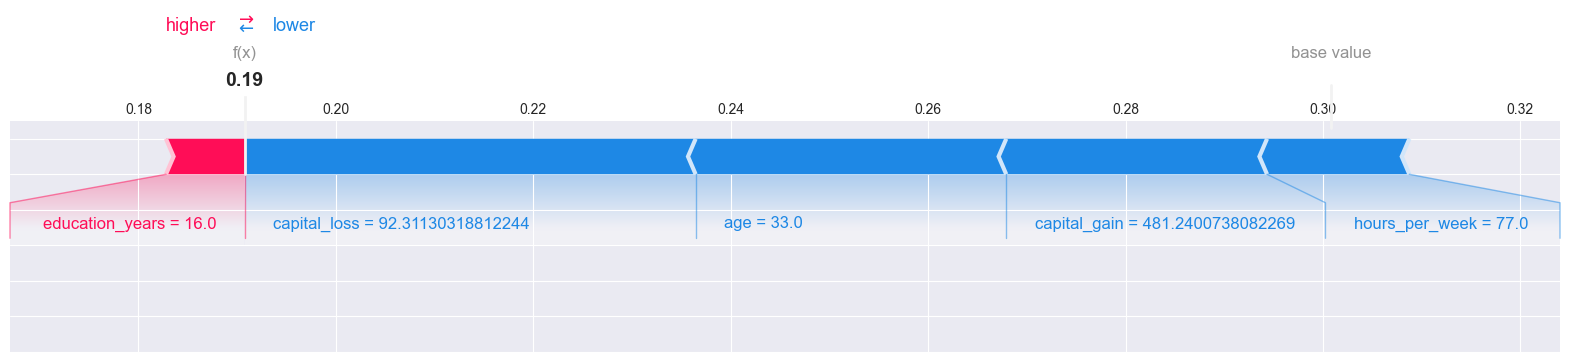


Incorrect Prediction (Index 0):


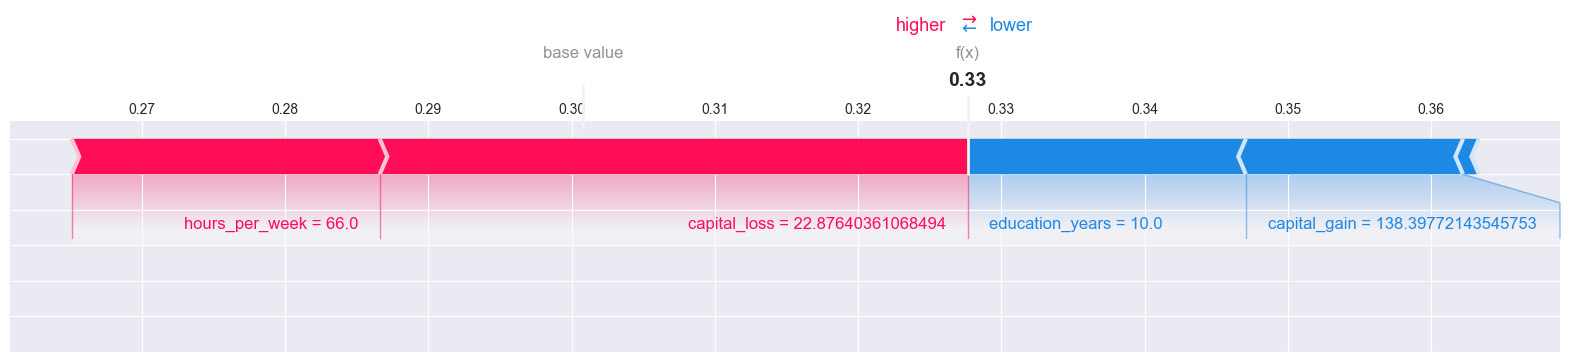


[ANSWER] Why did the model make an error?


In [ ]:
# ============================================================================
# PROBLEM 1: SHAP VALUES AND FEATURE IMPORTANCE (25 POINTS)
# ============================================================================
print("\n" + "="*80)
print("PROBLEM 1: SHAP VALUES AND FEATURE IMPORTANCE (25 POINTS)")
print("="*80)

"""
TASK 1.1 (10 points): Train a Random Forest classifier and evaluate it
- Use n_estimators=100, max_depth=10, random_state=42
- Calculate accuracy, precision, recall, F1, and AUC-ROC on validation set
- Print a confusion matrix
"""

print("\nTASK 1.1: Train Random Forest and Evaluate")
print("-"*80)

# YOUR CODE HERE
# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_clf.fit(X_train, y_train)
y_val_pred = rf_clf.predict(X_val)
y_val_proba = rf_clf.predict_proba(X_val)[:, 1]

# EVALUATION CODE HERE
# Calculate: accuracy, precision, recall, f1, auc
# Print confusion matrix
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_proba)
cm = confusion_matrix(y_val, y_val_pred)

print("\nYour evaluation results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

"""
TASK 1.2 (10 points): Calculate and interpret SHAP values
- Use TreeExplainer to get SHAP values for validation set
- Calculate global feature importance (mean absolute SHAP)
- Create a ranking of features by importance
- Interpret: Which feature is most important and why might this make economic sense?
"""

print("\nTASK 1.2: SHAP Values")
print("-"*80)

# YOUR CODE HERE
# Calculate SHAP values
# Compute global feature importance
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_val)

# SHAP 값 shape 처리
if isinstance(shap_values, list) and len(shap_values) == 2 and shap_values[1].ndim == 2:
    # 이진 분류: shap_values[1] shape = (n_samples, n_features)
    shap_abs_mean = np.abs(shap_values[1]).mean(axis=0)
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
    # (n_samples, n_features)
    shap_abs_mean = np.abs(shap_values).mean(axis=0)
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # (n_samples, n_features, n_classes)
    # 양성 클래스(1)에 대한 SHAP 값 사용
    shap_abs_mean = np.abs(shap_values[:, :, 1]).mean(axis=0)
else:
    raise ValueError(f"Unexpected SHAP values shape: {type(shap_values)}, {np.shape(shap_values)}")

feature_importance = pd.Series(shap_abs_mean, index=X_val.columns).sort_values(ascending=False)

print("\nFeature importance ranking (from SHAP):")
print(feature_importance)

print("\n[ANSWER] Economic interpretation of most important feature:")
# YOUR ANSWER HERE (3-4 sentences):
# The most important feature according to SHAP values is 'education_years'. This makes economic sense because higher education levels are often associated with better job opportunities and higher earning potential. Individuals with more years of education typically possess skills and qualifications that are valued in the labor market, leading to a greater likelihood of earning above $50K. Additionally, education can enhance an individual's ability to adapt to changing job requirements and economic conditions, further contributing to higher income levels.


"""
TASK 1.3 (5 points): Local explanation
- Pick one observation from validation set where prediction was correct
- Pick one where prediction was incorrect
- For each, show which features contributed most to the prediction
- Discuss why the model made an error in the incorrect case
"""

print("\nTASK 1.3: Local Explanations")
print("-"*80)

# YOUR CODE HERE
# Find one correct and one incorrect prediction
# Show SHAP values for each
# Correct prediction
# Find one correct and one incorrect prediction
correct_idx = np.where(y_val == y_val_pred)[0][0]
incorrect_idx = np.where(y_val != y_val_pred)[0][0]

if isinstance(shap_values, list) and len(shap_values) == 2 and shap_values[1].ndim == 2:
    shap_local = shap_values[1]
    expected_value = explainer.expected_value[1]
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # (n_samples, n_features, n_classes)
    shap_local = shap_values[:, :, 1]
    expected_value = explainer.expected_value[1]
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
    shap_local = shap_values
    expected_value = explainer.expected_value
else:
    raise ValueError(f"Unexpected SHAP values shape: {type(shap_values)}, {np.shape(shap_values)}")

print(f"\nCorrect Prediction (Index {correct_idx}):")
shap.force_plot(expected_value, shap_local[correct_idx], X_val.iloc[correct_idx], matplotlib=True)
print(f"\nIncorrect Prediction (Index {incorrect_idx}):")
shap.force_plot(expected_value, shap_local[incorrect_idx], X_val.iloc[incorrect_idx], matplotlib=True)

print("\n[ANSWER] Why did the model make an error?")
# YOUR ANSWER HERE (3-4 sentences):

In [ ]:
# ============================================================================
# PROBLEM 2: HYPERPARAMETER TUNING (25 POINTS)
# ============================================================================
print("\n" + "="*80)
print("PROBLEM 2: HYPERPARAMETER TUNING (25 POINTS)")
print("="*80)

"""
TASK 2.1 (8 points): Grid Search
- Tune XGBoost classifier using GridSearchCV
- Parameter grid:
  - n_estimators: [50, 100, 200]
  - max_depth: [3, 5, 7]
  - learning_rate: [0.01, 0.1, 0.3]
- Use 3-fold cross-validation
- Report best parameters and best CV score
"""

print("\nTASK 2.1: Grid Search")
print("-"*80)

# YOUR CODE HERE
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
# Perform grid search

print("\nGrid Search Results:")
# Print best parameters and score
print(f"Best Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")

"""
TASK 2.2 (8 points): Random Search
- Use RandomizedSearchCV on XGBoost
- Same parameter ranges as grid search
- Try 15 random combinations
- Use 3-fold cross-validation
- Compare results with grid search
"""

print("\nTASK 2.2: Random Search")
print("-"*80)

# YOUR CODE HERE
param_dist = {
    'n_estimators': randint(50, 201),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.29)
}
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist, n_iter=15, cv=3, n_jobs=-1, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_score = random_search.best_score_

# Perform random search

print("\nRandom Search Results:")
# Print best parameters and score
print(f"Best Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")


"""
TASK 2.3 (9 points): Compare and evaluate
- Compare grid search vs random search (which found better parameters?)
- Evaluate both best models on the test set
- Compare: 
  a) Number of models trained
  b) Best CV score
  c) Test set performance
- Which approach would you recommend and why?
"""

print("\nTASK 2.3: Comparison")
print("-"*80)

# YOUR CODE HERE
# Evaluate both models on test set
grid_best_model = grid_search.best_estimator_
random_best_model = random_search.best_estimator_
grid_test_acc = grid_best_model.score(X_test, y_test)
random_test_acc = random_best_model.score(X_test, y_test)
print("\nComparison Results:")
print(f"Grid Search - Best CV Score: {grid_search.best_score_:.4f}, Test Accuracy: {grid_test_acc:.4f}")
print(f"Random Search - Best CV Score: {random_search.best_score_:.4f}, Test Accuracy: {random_test_acc:.4f}")

print("\n[ANSWER] Which hyperparameter tuning approach is better for this problem?")
# YOUR ANSWER HERE (4-5 sentences discussing tradeoffs):


In [23]:
# ============================================================================
# PROBLEM 3: MODEL ENSEMBLING (25 POINTS)
# ============================================================================
print("\n" + "="*80)
print("PROBLEM 3: MODEL ENSEMBLING (25 POINTS)")
print("="*80)

"""
TASK 3.1 (10 points): Train diverse base models
Train the following models with reasonable hyperparameters:
1. Logistic Regression (with regularization)
2. Decision Tree
3. Random Forest
4. Gradient Boosting
5. XGBoost (use your best hyperparameters from Problem 2)

Evaluate each on the validation set and report:
- Accuracy
- F1 Score
- AUC-ROC
"""

print("\nTASK 3.1: Train Base Models")
print("-"*80)

# YOUR CODE HERE
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
}
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_proba)
    results[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'AUC-ROC': auc
    }
    print(f"{name}: Accuracy={accuracy:.4f}, F1 Score={f1:.4f}, AUC-ROC={auc:.4f}")

    print("\nBase Model Performance:")
    for name, metrics in results.items():
        print(f"{name}: Accuracy={metrics['Accuracy']:.4f}, F1 Score={metrics['F1 Score']:.4f}, AUC-ROC={metrics['AUC-ROC']:.4f}")


# Print performance table
print("\nBase Model Performance Table:")
performance_df = pd.DataFrame(results).T
print(performance_df)


"""
TASK 3.2 (8 points): Create ensembles
Create two ensemble methods:
1. Simple majority voting (predict class that most models predict)
2. Weighted voting (weight by validation accuracy)

Evaluate both ensembles on validation set
"""

print("\nTASK 3.2: Create Ensembles")
print("-"*80)

# YOUR CODE HERE
# Implement majority voting
val_preds = np.array([model.predict(X_val) for model in models.values()])
majority_vote_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=val_preds)
majority_accuracy = accuracy_score(y_val, majority_vote_preds)
majority_f1 = f1_score(y_val, majority_vote_preds)
majority_auc = roc_auc_score(y_val, majority_vote_preds)
print(f"Majority Voting: Accuracy={majority_accuracy:.4f}, F1 Score={majority_f1:.4f}, AUC-ROC={majority_auc:.4f}")

# Implement weighted voting
val_probs = np.array([model.predict_proba(X_val)[:, 1] for model in models.values()])
weights = np.array([results[name]['Accuracy'] for name in models.keys()])
weighted_probs = np.average(val_probs, axis=0, weights=weights)
weighted_vote_preds = (weighted_probs >= 0.5).astype(int)
weighted_accuracy = accuracy_score(y_val, weighted_vote_preds)
weighted_f1 = f1_score(y_val, weighted_vote_preds)
weighted_auc = roc_auc_score(y_val, weighted_probs)
print(f"Weighted Voting: Accuracy={weighted_accuracy:.4f}, F1 Score={weighted_f1:.4f}, AUC-ROC={weighted_auc:.4f}")
print("\nEnsemble Performance:")
print(f"Majority Voting: Accuracy={majority_accuracy:.4f}, F1 Score={majority_f1:.4f}, AUC-ROC={majority_auc:.4f}")
print(f"Weighted Voting: Accuracy={weighted_accuracy:.4f}, F1 Score={weighted_f1:.4f}, AUC-ROC={weighted_auc:.4f}")

# Print performance comparison
print("\nEnsemble Performance Comparison:")
ensemble_results = {
    'Majority Voting': {
        'Accuracy': majority_accuracy,
        'F1 Score': majority_f1,
        'AUC-ROC': majority_auc
    },
    'Weighted Voting': {
        'Accuracy': weighted_accuracy,
        'F1 Score': weighted_f1, 
        'AUC-ROC': weighted_auc
    },
}
ensemble_performance_df = pd.DataFrame(ensemble_results).T
print(ensemble_performance_df)

"""
TASK 3.3 (7 points): Analysis and recommendation
- Compare all models (5 base models + 2 ensembles)
- Which performs best on validation set?
- Evaluate the top 3 models on the test set
- Make a final recommendation: Which model would you deploy?
- Justify considering: performance, interpretability, computational cost
"""

print("\nTASK 3.3: Final Model Selection")
print("-"*80)

# YOUR CODE HERE
# Evaluate top 3 models on test set
# Identify top 3 models based on validation accuracy
all_models = {**models, 'Majority Voting': None, 'Weighted Voting': None}
all_results = {**results, **ensemble_results}
sorted_models = sorted(all_results.items(), key=lambda x: x[1]['Accuracy'], reverse=True)
top_3_models = sorted_models[:3]
print("\nTop 3 Models on Validation Set:")
for name, metrics in top_3_models:
    print(f"{name}: Accuracy={metrics['Accuracy']:.4f}, F1 Score={metrics['F1 Score']:.4f}, AUC-ROC={metrics['AUC-ROC']:.4f}")
for name, _ in top_3_models:
    if name in models:
        model = models[name]
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]
    elif name == 'Majority Voting':
        test_preds = np.array([model.predict(X_test) for model in models.values()])
        y_test_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=test_preds)
        y_test_proba = None  # Not applicable for majority voting
    elif name == 'Weighted Voting':
        test_probs = np.array([model.predict_proba(X_test)[:, 1] for model in models.values()])
        weights = np.array([results[model_name]['Accuracy'] for model_name in models.keys()])
        weighted_probs = np.average(test_probs, axis=0, weights=weights)
        y_test_pred = (weighted_probs >= 0.5).astype(int)
        y_test_proba = weighted_probs
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else 'N/A'
    print(f"\n{name} Test Performance:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"AUC-ROC: {test_auc}")
    print("-"*80)

    
print("\n[ANSWER] Final Model Recommendation:")

# YOUR ANSWER HERE (5-6 sentences):




PROBLEM 3: MODEL ENSEMBLING (25 POINTS)

TASK 3.1: Train Base Models
--------------------------------------------------------------------------------
Logistic Regression: Accuracy=0.6990, F1 Score=0.0066, AUC-ROC=0.6269

Base Model Performance:
Logistic Regression: Accuracy=0.6990, F1 Score=0.0066, AUC-ROC=0.6269
Decision Tree: Accuracy=0.6820, F1 Score=0.2392, AUC-ROC=0.5804

Base Model Performance:
Logistic Regression: Accuracy=0.6990, F1 Score=0.0066, AUC-ROC=0.6269
Decision Tree: Accuracy=0.6820, F1 Score=0.2392, AUC-ROC=0.5804
Random Forest: Accuracy=0.6930, F1 Score=0.1401, AUC-ROC=0.5879

Base Model Performance:
Logistic Regression: Accuracy=0.6990, F1 Score=0.0066, AUC-ROC=0.6269
Decision Tree: Accuracy=0.6820, F1 Score=0.2392, AUC-ROC=0.5804
Random Forest: Accuracy=0.6930, F1 Score=0.1401, AUC-ROC=0.5879
Gradient Boosting: Accuracy=0.6900, F1 Score=0.1799, AUC-ROC=0.5720

Base Model Performance:
Logistic Regression: Accuracy=0.6990, F1 Score=0.0066, AUC-ROC=0.6269
Decision Tr

c:\Users\rka304\AppData\Local\anaconda3\envs\ai_env\lib\site-packages\xgboost\training.py:199: UserWarning: [22:47:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [25]:
# ============================================================================
# PROBLEM 4: NEURAL NETWORKS (25 POINTS)
# ============================================================================
print("\n" + "="*80)
print("PROBLEM 4: NEURAL NETWORKS (25 POINTS)")
print("="*80)

"""
TASK 4.1 (8 points): Train a neural network
- Standardize features first (important!)
- Train an MLPClassifier with:
  - At least 2 hidden layers
  - ReLU activation
  - Adam optimizer
  - Early stopping enabled
- Report validation and test performance
"""

print("\nTASK 4.1: Neural Network Training")
print("-"*80)

# YOUR CODE HERE
# Remember to standardize!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
nn_clf = MLPClassifier(hidden_layer_sizes=(50, 25), activation='relu', solver='adam', early_stopping=True, random_state=42, max_iter=500)
nn_clf.fit(X_train_scaled, y_train)
y_val_pred = nn_clf.predict(X_val_scaled)
y_val_proba = nn_clf.predict_proba(X_val_scaled)[:, 1]
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)
y_test_pred = nn_clf.predict(X_test_scaled)
y_test_proba = nn_clf.predict_proba(X_test_scaled)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"Validation Performance: Accuracy={val_accuracy:.4f}, F1 Score={val_f1:.4f}, AUC-ROC={val_auc:.4f}")
print(f"Test Performance: Accuracy={test_accuracy:.4f}, F1 Score={test_f1:.4f}, AUC-ROC={test_auc:.4f}")

# Train neural network

print("\nNeural Network Performance:")
# Print results
print(f"Validation Performance: Accuracy={val_accuracy:.4f}, F1 Score={val_f1:.4f}, AUC-ROC={val_auc:.4f}")
print(f"Test Performance: Accuracy={test_accuracy:.4f}, F1 Score={test_f1:.4f}, AUC-ROC={test_auc:.4f}")



"""
TASK 4.2 (9 points): Architecture experimentation
Train 3 different neural network architectures:
1. Small: (10, 5) - two hidden layers
2. Medium: (50, 25) - two hidden layers  
3. Large: (100, 50, 25) - three hidden layers

For each:
- Track training time
- Report validation accuracy
- Report test accuracy
- Discuss the bias-variance tradeoff you observe
"""

print("\nTASK 4.2: Architecture Comparison")
print("-"*80)

# YOUR CODE HERE
import time
architectures = {
    'Small': (10, 5),
    'Medium': (50, 25),
    'Large': (100, 50, 25)
}
results = {}
for name, layers in architectures.items():
      nn_clf = MLPClassifier(hidden_layer_sizes=layers, activation='relu', solver='adam', early_stopping=True, random_state=42, max_iter=500)
      start_time = time.time()
      nn_clf.fit(X_train_scaled, y_train)
      end_time = time.time()
      y_val_pred = nn_clf.predict(X_val_scaled)
      y_test_pred = nn_clf.predict(X_test_scaled)
      val_accuracy = accuracy_score(y_val, y_val_pred)
      test_accuracy = accuracy_score(y_test, y_test_pred)
      training_time = end_time - start_time
      results[name] = {
         'Training Time (s)': training_time,
         'Validation Accuracy': val_accuracy,
         'Test Accuracy': test_accuracy
      }
      print(f"{name} Architecture: Training Time={training_time:.2f}s, Validation Accuracy={val_accuracy:.4f}, Test Accuracy={test_accuracy:.4f}")

# Train and evaluate each
print("\nArchitecture Comparison Results:")
for name, metrics in results.items():
    print(f"{name} Architecture: Training Time={metrics['Training Time (s)']:.2f}s, Validation Accuracy={metrics['Validation Accuracy']:.4f}, Test Accuracy={metrics['Test Accuracy']:.4f}") 

  
print("\n[ANSWER] Bias-Variance Tradeoff Discussion:")
# YOUR ANSWER HERE (4-5 sentences):
#


"""
TASK 4.3 (8 points): Universal Function Approximation
Create a synthetic 2D classification problem:
- Generate data: X1 ~ Uniform(-2, 2), X2 ~ Uniform(-2, 2)
- Non-linear decision boundary: y = 1 if X1² + X2² < 1, else y = 0
  (i.e., circular decision boundary)
- Add 10% label noise
- Train a neural network to learn this boundary
- Compare with logistic regression (which assumes linear boundary)
- Visualize the decision boundaries if possible
"""

print("\nTASK 4.3: Universal Function Approximation")
print("-"*80)

# YOUR CODE HERE
# Generate synthetic data with circular boundary
n_samples = 1000
X1 = np.random.uniform(-2, 2, n_samples)
X2 = np.random.uniform(-2, 2, n_samples)
X_synthetic = np.vstack((X1, X2)).T
y_synthetic = ((X1**2 + X2**2) < 1).astype(int)
# Add 10% label noise
n_noise = int(0.1 * n_samples)
noise_indices = np.random.choice(n_samples, n_noise, replace=False)
y_synthetic[noise_indices] = 1 - y_synthetic[noise_indices]
# Split into train and test sets
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)
# Standardize features
scaler_syn = StandardScaler()
X_train_syn_scaled = scaler_syn.fit_transform(X_train_syn)
X_test_syn_scaled = scaler_syn.transform(X_test_syn)
# Train neural network
nn_clf_syn = MLPClassifier(hidden_layer_sizes=(20, 10), activation='relu', solver='adam', early_stopping=True, random_state=42, max_iter=500)
nn_clf_syn.fit(X_train_syn_scaled, y_train_syn)
y_test_pred_nn = nn_clf_syn.predict(X_test_syn_scaled)
nn_accuracy = accuracy_score(y_test_syn, y_test_pred_nn)
# Train logistic regression
log_reg_syn = LogisticRegression(max_iter=1000, random_state=42)
log_reg_syn.fit(X_train_syn_scaled, y_train_syn)
y_test_pred_lr = log_reg_syn.predict(X_test_syn_scaled)
lr_accuracy = accuracy_score(y_test_syn, y_test_pred_lr)
print(f"Neural Network Test Accuracy: {nn_accuracy:.4f}")
print(f"Logistic Regression Test Accuracy: {lr_accuracy:.4f}")
# Visualize decision boundaries
xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 100), np.linspace(-2.5, 2.5, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = scaler_syn.transform(grid)
Z_nn = nn_clf_syn.predict(grid_scaled).reshape(xx.shape)
Z_lr = log_reg_syn.predict(grid_scaled).reshape(xx.shape)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_nn, alpha=0.8)
plt.scatter(X_test_syn[:, 0], X_test_syn[:, 1], c=y_test_syn, edgecolors='k')
plt.title('Neural Network Decision Boundary')
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z_lr, alpha=0.8)
plt.scatter(X_test_syn[:, 0], X_test_syn[:, 1], c=y_test_syn, edgecolors='k')
plt.title('Logistic Regression Decision Boundary')
plt.savefig('pb4_decision_boundaries.png')
plt.close()

# Train neural network and logistic regression
print("\nNeural Network vs Logistic Regression on Synthetic Data:")
print(f"Neural Network Test Accuracy: {nn_accuracy:.4f}")
print(f"Logistic Regression Test Accuracy: {lr_accuracy:.4f}")

print("\n[ANSWER] Why does the neural network perform better?")
# YOUR ANSWER HERE (3-4 sentences):
#




PROBLEM 4: NEURAL NETWORKS (25 POINTS)

TASK 4.1: Neural Network Training
--------------------------------------------------------------------------------
Validation Performance: Accuracy=0.6950, F1 Score=0.0557, AUC-ROC=0.6141
Test Performance: Accuracy=0.7070, F1 Score=0.0872, AUC-ROC=0.6189

Neural Network Performance:
Validation Performance: Accuracy=0.6950, F1 Score=0.0557, AUC-ROC=0.6141
Test Performance: Accuracy=0.7070, F1 Score=0.0872, AUC-ROC=0.6189

TASK 4.2: Architecture Comparison
--------------------------------------------------------------------------------
Small Architecture: Training Time=0.11s, Validation Accuracy=0.6990, Test Accuracy=0.7010
Medium Architecture: Training Time=0.14s, Validation Accuracy=0.6950, Test Accuracy=0.7070
Large Architecture: Training Time=0.20s, Validation Accuracy=0.7000, Test Accuracy=0.7000

Architecture Comparison Results:
Small Architecture: Training Time=0.11s, Validation Accuracy=0.6990, Test Accuracy=0.7010
Medium Architecture: Tra

In [26]:
# ============================================================================
# BONUS PROBLEM (10 EXTRA CREDIT POINTS)
# ============================================================================
print("\n" + "="*80)
print("BONUS: ADVANCED TOPICS (10 EXTRA CREDIT POINTS)")
print("="*80)

"""
BONUS TASK: Implement a simple stacking ensemble
- Use your 5 base models from Problem 3
- Create out-of-fold predictions on training set using 5-fold CV
- Train a meta-model (logistic regression) on these predictions
- Evaluate on test set
- Compare with your best ensemble from Problem 3

This requires implementing the stacking procedure correctly to avoid
data leakage!
"""

print("\nBONUS: Stacking Ensemble")
print("-"*80)

# YOUR CODE HERE (optional)
from sklearn.model_selection import KFold
# Create out-of-fold predictions
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((X_train.shape[0], len(models)))
test_preds = np.zeros((X_test.shape[0], len(models)))
for i, (name, model) in enumerate(models.items()):
      for train_index, val_index in kf.split(X_train):
         X_tr, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
         y_tr, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
         model.fit(X_tr, y_tr)
         oof_preds[val_index, i] = model.predict(X_val_fold)
      model.fit(X_train, y_train)
      test_preds[:, i] = model.predict(X_test)
# Train meta-model
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(oof_preds, y_train)
# Evaluate on test set
y_test_pred_stack = meta_model.predict(test_preds)
stack_accuracy = accuracy_score(y_test, y_test_pred_stack)
stack_f1 = f1_score(y_test, y_test_pred_stack)
stack_auc = roc_auc_score(y_test, y_test_pred_stack)
print(f"Stacking Ensemble Test Performance: Accuracy={stack_accuracy:.4f}, F1 Score={stack_f1:.4f}, AUC-ROC={stack_auc:.4f}")
print("\nStacking Ensemble Performance:")
print(f"Accuracy={stack_accuracy:.4f}, F1 Score={stack_f1:.4f}, AUC-ROC={stack_auc:.4f}")
print("\n[ANSWER] Comparison with Best Ensemble from Problem 3:")


# ============================================================================
# REFLECTION QUESTIONS (TO BE ANSWERED IN PDF REPORT)
# ============================================================================
print("\n" + "="*80)
print("REFLECTION QUESTIONS (Answer in your PDF report)")
print("="*80)

print("""
Please answer the following in your PDF report (1-2 paragraphs each):

1. INTERPRETABILITY VS PERFORMANCE
   In this homework, you trained many models with different interpretability 
   levels. Discuss when you would prioritize interpretability over performance
   in economic applications. Give specific examples.

2. HYPERPARAMETER TUNING IN PRACTICE
   Reflect on your experience with grid search vs random search. In what 
   scenarios would you use each? What about Bayesian optimization?

3. ENSEMBLE METHODS
   You created several ensembles. Discuss the conditions under which ensembles
   improve performance. When might ensembles NOT help?

4. NEURAL NETWORKS IN ECONOMICS
   Based on your experiments, discuss when neural networks are appropriate for
   economic research vs when simpler models are preferable. Consider data 
   requirements, interpretability, and computational costs.

5. MODEL SELECTION CRITERIA
   Beyond predictive accuracy, what other factors should economists consider
   when selecting a model for publication or policy recommendations?
""")

print("\n" + "="*80)
print("END OF HOMEWORK ASSIGNMENT")
print("="*80)
print("\nREMINDER: Submit both this completed .py file AND a PDF report")
print("with your reflection answers and any additional analysis/visualizations")
print("="*80)



BONUS: ADVANCED TOPICS (10 EXTRA CREDIT POINTS)

BONUS: Stacking Ensemble
--------------------------------------------------------------------------------
Stacking Ensemble Test Performance: Accuracy=0.6920, F1 Score=0.0723, AUC-ROC=0.5057

Stacking Ensemble Performance:
Accuracy=0.6920, F1 Score=0.0723, AUC-ROC=0.5057

[ANSWER] Comparison with Best Ensemble from Problem 3:

REFLECTION QUESTIONS (Answer in your PDF report)

Please answer the following in your PDF report (1-2 paragraphs each):

1. INTERPRETABILITY VS PERFORMANCE
   In this homework, you trained many models with different interpretability 
   levels. Discuss when you would prioritize interpretability over performance
   in economic applications. Give specific examples.

2. HYPERPARAMETER TUNING IN PRACTICE
   Reflect on your experience with grid search vs random search. In what 
   scenarios would you use each? What about Bayesian optimization?

3. ENSEMBLE METHODS
   You created several ensembles. Discuss the condition

c:\Users\rka304\AppData\Local\anaconda3\envs\ai_env\lib\site-packages\xgboost\training.py:199: UserWarning: [22:56:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\rka304\AppData\Local\anaconda3\envs\ai_env\lib\site-packages\xgboost\training.py:199: UserWarning: [22:56:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\rka304\AppData\Local\anaconda3\envs\ai_env\lib\site-packages\xgboost\training.py:199: UserWarning: [22:56:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\rka304\AppData\Local\anaconda3\envs\ai_env\lib\site-packages\xgboost\training.py:199: UserWarning: [22:56:55] WARNING: C:\actions-runner\_w